In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
torch.set_printoptions(threshold=torch.inf)
import numpy as np
import random

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

sys.path.append(os.path.dirname(os.getcwd())) #Add project dir to path
# from utils.loadutils import standardize_vidimu
# from utils.loadutils2 import standardize_vidimu
# from utils.loadutils3 import standardize_vidimu
from utils.loadutils4 import standardize_vidimu

def set_random_seed(seed=42):
    """Set random seed for reproducibility."""
    random.seed(seed)            # Python random module
    np.random.seed(seed)         # NumPy
    torch.manual_seed(seed)      # PyTorch
    torch.cuda.manual_seed_all(seed)  # For multi-GPU systems

    # Ensure deterministic behavior in some backends (optional)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call this at the beginning of your training script
set_random_seed(42)


In [2]:
# fulldatasetpath = '/Volumes/Data_Drive/datasets/VIDIMU'
# dpath = os.path.join(fulldatasetpath,'dataset','videoandimusyncrop')
dpath = '/Volumes/Data_Drive/datasets/VIDIMU/dataset/videoandimusyncrop'
# model_out_path = '/Volumes/Data_Drive/model_out_junk'
model_out_path = '/Volumes/Data_Drive/model_out_old/model_out_junk1'
# valpath = os.path.join(fulldatasetpath,'dataset','videonly')
activities = ["A01", "A02", "A03", "A04", "A05", "A06", "A07", "A08", "A09", "A10", "A11", "A12", "A13"]
num_classes = len(activities)  # Number of activities

In [3]:
'''
VIDIMU

ins = 'VID', 'IMU', 'VIDIMU'
out = 'IMU', 'act'
'''

secs = 4.0
imu_window_size = int(secs * 50)
video_window_size = int(secs * 30)
print('IMU Data window size:', imu_window_size)
print('Video Data window size:', video_window_size)

train_loader, test_loader = standardize_vidimu(dpath, 
                                               time_in_seconds=secs, 
                                               split=0.8, 
                                               batch_size=32,
                                               activities = activities,
                                               ins='VIDIMU', 
                                               out='act')


# Get a batch from the training loader and check its shape
for vid_batch, imu_batch, label_batch in train_loader:
    print(f"Batch VID shape: {vid_batch.shape}, Batch IMU shape: {imu_batch.shape}")
    print(f"Batch label shape: {label_batch.shape}")
    vid_channels = vid_batch.shape[1]
    imu_channels = imu_batch.shape[1]
    break

IMU Data window size: 200
Video Data window size: 120
Fetching data files...
Found 208 IMU files and 208 video files
Loading and preprocessing data...
IMU min shape: torch.Size([39, 1]), IMU max shape: torch.Size([39, 1])
Video min shape: torch.Size([102, 1]), Video max shape: torch.Size([102, 1])
Batch VID shape: torch.Size([32, 102, 120]), Batch IMU shape: torch.Size([32, 39, 200])
Batch label shape: torch.Size([32])


In [4]:
def check_scaled_min_max(loader):
    # Get the number of channels for IMU and Video data from the first batch
    imu_channels = loader.dataset.dataset.all_imu_windows.shape[1]
    video_channels = loader.dataset.dataset.all_video_windows.shape[1]

    # Initialize min and max values for each channel
    imu_min_per_channel = torch.full((imu_channels,), float('inf'))
    imu_max_per_channel = torch.full((imu_channels,), float('-inf'))
    video_min_per_channel = torch.full((video_channels,), float('inf'))
    video_max_per_channel = torch.full((video_channels,), float('-inf'))

    # Iterate over the loader to update the min and max for each channel
    for video_batch, imu_batch, _ in loader:
        # Compute min and max across the window dimension for each channel
        batch_imu_min = imu_batch.min(dim=2)[0].min(dim=0)[0]  # Shape: (num_channels,)
        batch_imu_max = imu_batch.max(dim=2)[0].max(dim=0)[0]  # Shape: (num_channels,)
        batch_video_min = video_batch.min(dim=2)[0].min(dim=0)[0]  # Shape: (num_channels,)
        batch_video_max = video_batch.max(dim=2)[0].max(dim=0)[0]  # Shape: (num_channels,)

        # Update global min and max for each channel
        imu_min_per_channel = torch.min(imu_min_per_channel, batch_imu_min)
        imu_max_per_channel = torch.max(imu_max_per_channel, batch_imu_max)
        video_min_per_channel = torch.min(video_min_per_channel, batch_video_min)
        video_max_per_channel = torch.max(video_max_per_channel, batch_video_max)

    return imu_min_per_channel, imu_max_per_channel, video_min_per_channel, video_max_per_channel

# Check channel-wise min and max for training data
scaled_train_imu_min, scaled_train_imu_max, scaled_train_video_min, scaled_train_video_max = check_scaled_min_max(train_loader)
print("\nScaled Training Data Min-Max:")
print(f"IMU Min (per channel): {scaled_train_imu_min}")
print(f"IMU Max (per channel): {scaled_train_imu_max}")
print(f'IMU shape: {scaled_train_imu_min.shape}\n')
print(f"Video Min (per channel): {scaled_train_video_min}")
print(f"Video Max (per channel): {scaled_train_video_max}")
print(f'Video shape: {scaled_train_video_min.shape}')

# Check channel-wise min and max for testing data
scaled_test_imu_min, scaled_test_imu_max, scaled_test_video_min, scaled_test_video_max = check_scaled_min_max(test_loader)
print("\nScaled Testing Data Min-Max:")
print(f"IMU Min (per channel): {scaled_test_imu_min}")
print(f"IMU Max (per channel): {scaled_test_imu_max}")
print(f'IMU shape: {scaled_test_imu_min.shape}\n')
print(f"Video Min (per channel): {scaled_test_video_min}")
print(f"Video Max (per channel): {scaled_test_video_max}")
print(f'Video shape: {scaled_test_video_min.shape}')


Scaled Training Data Min-Max:
IMU Min (per channel): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
IMU Max (per channel): tensor([1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 0., 0.])
IMU shape: torch.Size([39])

Video Min (per channel): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
Video Max (per channel): tensor([1., 1., 1., 1., 1., 1., 1., 1., 1

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TemporalConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, stride=1, dropout=0.2):
        super(TemporalConvBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, 
                               stride=stride, padding=(kernel_size - 1) // 2, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 
                               stride=stride, padding=(kernel_size - 1) // 2, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.residual_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.residual_connection(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + residual
        out = self.relu(out)
        return out

class TemporalResNetMultiInput(nn.Module):
    def __init__(self, imu_channels, video_channels, num_classes, num_blocks, hidden_channels=64, kernel_size=3, dilation=1, dropout=0.2):
        super(TemporalResNetMultiInput, self).__init__()

        # Separate input layers for IMU and video
        self.imu_input_layer = nn.Conv1d(imu_channels, hidden_channels, kernel_size=1)
        self.video_input_layer = nn.Conv1d(video_channels, hidden_channels, kernel_size=1)

        # Separate residual layers for IMU and video
        imu_layers = [TemporalConvBlock(hidden_channels, hidden_channels, kernel_size, dilation, dropout=dropout) for _ in range(num_blocks)]
        video_layers = [TemporalConvBlock(hidden_channels, hidden_channels, kernel_size, dilation, dropout=dropout) for _ in range(num_blocks)]
        self.imu_residual_layers = nn.Sequential(*imu_layers)
        self.video_residual_layers = nn.Sequential(*video_layers)

        # Global pooling to ensure compatibility for different input sequence lengths
        self.imu_global_pool = nn.AdaptiveAvgPool1d(1)
        self.video_global_pool = nn.AdaptiveAvgPool1d(1)

        # Output layer after fusion
        self.output_layer = nn.Linear(hidden_channels * 2, num_classes)

    def forward(self, imu_data, video_data):
        # Process IMU data
        imu_data = self.imu_input_layer(imu_data)
        imu_data = self.imu_residual_layers(imu_data)
        imu_data = self.imu_global_pool(imu_data).squeeze(-1)  # Global avg pooling to get (batch_size, hidden_channels)

        # Process video data
        video_data = self.video_input_layer(video_data)
        video_data = self.video_residual_layers(video_data)
        video_data = self.video_global_pool(video_data).squeeze(-1)  # Global avg pooling to get (batch_size, hidden_channels)

        # Concatenate pooled outputs
        combined = torch.cat([imu_data, video_data], dim=1)  # Shape: (batch_size, hidden_channels * 2)
        output = self.output_layer(combined)
        return output

# Define different ResNet depths
def TemporalResNet14MultiInput(imu_channels, video_channels, num_classes, **kwargs):
    return TemporalResNetMultiInput(imu_channels, video_channels, num_classes, num_blocks=14, **kwargs)


# # Example usage
# if __name__ == '__main__':

#     model = TemporalResNet14MultiInput(imu_channels, vid_channels, num_classes)
#     print(model)

#     # Dummy input (batch_size, channels, sequence_length)
#     imu_data = torch.randn(32, imu_channels, imu_window_size)    # IMU input: 32 samples, 39 channels, length 167
#     video_data = torch.randn(32, vid_channels, video_window_size)  # Video input: 32 samples, 102 channels, length 100
#     output = model(imu_data, video_data)
#     print(output.shape)  # Expected: (32, num_classes)

In [6]:
class TemporalConvBlock(nn.Module):
    """A residual block with two 1D convolutions, BatchNorm, ReLU, and residual connection."""
    def __init__(self, in_channels, out_channels, kernel_size, dilation, stride=1, dropout=0.2):
        super(TemporalConvBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, 
                               stride=stride, padding=(kernel_size - 1) // 2, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)  # Batch Normalization after the first convolution

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 
                               stride=stride, padding=(kernel_size - 1) // 2, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)  # Batch Normalization after the second convolution

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

        # Define a 1x1 Conv for adjusting input dimensions (if in_channels != out_channels)
        self.residual_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.residual_connection(x)
        out = self.conv1(x)
        out = self.bn1(out)  # Apply BatchNorm after first convolution
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)  # Apply BatchNorm after second convolution
        out = out + residual  # Residual connection
        out = self.relu(out)
        return out

class TemporalResNet(nn.Module):
    """ResNet model with temporal convolutional layers."""
    def __init__(self, input_channels, num_classes, num_blocks, hidden_channels=64, kernel_size=3, dilation=1, dropout=0.2):
        super(TemporalResNet, self).__init__()
        self.input_layer = nn.Conv1d(input_channels, hidden_channels, kernel_size=1)

        # Stack the specified number of residual blocks
        layers = []
        for _ in range(num_blocks):
            layers.append(TemporalConvBlock(hidden_channels, hidden_channels, kernel_size, dilation, dropout=dropout))
        self.residual_layers = nn.Sequential(*layers)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.output_layer = nn.Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.residual_layers(x)
        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling across time dimension
        x = self.output_layer(x)
        return x

# Define different ResNet depths
def TemporalResNet14(input_channels, num_classes, **kwargs):
    return TemporalResNet(input_channels, num_classes, num_blocks=14, **kwargs)

def TemporalResNet20(input_channels, num_classes, **kwargs):
    return TemporalResNet(input_channels, num_classes, num_blocks=20, **kwargs)

def TemporalResNet26(input_channels, num_classes, **kwargs):
    return TemporalResNet(input_channels, num_classes, num_blocks=26, **kwargs)

def TemporalResNet32(input_channels, num_classes, **kwargs):
    return TemporalResNet(input_channels, num_classes, num_blocks=32, **kwargs)

def TemporalResNet56(input_channels, num_classes, **kwargs):
    return TemporalResNet(input_channels, num_classes, num_blocks=56, **kwargs)

def TemporalResNet110(input_channels, num_classes, **kwargs):
    return TemporalResNet(input_channels, num_classes, num_blocks=110, **kwargs)

def TemporalResNet164(input_channels, num_classes, **kwargs):
    return TemporalResNet(input_channels, num_classes, num_blocks=164, **kwargs)

# # Example usage
# if __name__ == '__main__':
#     model = TemporalResNet14(input_channels=8, num_classes=10)  # 8-channel input, 10 output classes
#     print(model)

#     # Create dummy input (batch_size, channels, sequence_length)
#     x = torch.randn(32, 8, 100)  # Batch of 32 samples, 8 channels, sequence length 100
#     output = model(x)
#     print(output.shape)  # Should be (32, num_classes)


In [7]:
# Updated testing function with confusion matrix and multi-class metrics
def test_model(student_model, test_loader, return_accuracy=False):
    student_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for vid_batch, imu_batch, y_batch in test_loader:
            vid_batch = vid_batch.float()
            outputs = student_model(vid_batch)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)

    if return_accuracy:
        return accuracy

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=activities, yticklabels=activities)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision, Recall, F1 (for multi-class classification)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro Average): {precision:.4f}")
    print(f"Recall (Macro Average): {recall:.4f}")
    print(f"F1-Score (Macro Average): {f1:.4f}")

In [8]:
def train_distillation(student_model, teacher_model, train_loader, test_loader, distillation_loss, optimizer, scheduler, modelname, num_epochs=20, model_path=None):
    # Load the initial student model if a path is provided
    if model_path and os.path.exists(model_path):
        student_model.load_state_dict(torch.load(model_path, weights_only=True))
        print(f"Loaded student model from {model_path}")

    student_model.train()
    best_accuracy = 0.0
    best_model_filename = None
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct_train = 0
        total_train = 0

        for vid_batch, imu_batch, y_batch in train_loader:
            vid_batch = vid_batch.float()
            imu_batch = imu_batch.float()
            y_batch = y_batch.long()
            optimizer.zero_grad()

            # Forward pass through teacher model
            with torch.no_grad():
                teacher_logits = teacher_model(imu_batch, vid_batch)

            # Forward pass through student model
            student_logits = student_model(vid_batch)

            # Calculate distillation loss
            loss = distillation_loss(student_logits, teacher_logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(student_logits, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Calculate test accuracy
        test_accuracy = test_model(student_model, test_loader, return_accuracy=True)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

        scheduler.step(test_accuracy)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr:.1e}")

        # Save the model with the best test accuracy
        if test_accuracy > best_accuracy:
            # Remove the previous best model
            if best_model_filename is not None and os.path.exists(best_model_filename):
                os.remove(best_model_filename)

            # Save the new best model
            best_accuracy = test_accuracy
            best_model_filename = f'{model_out_path}/best_{modelname}_acc_{best_accuracy:.4f}.pth'
            torch.save(student_model.state_dict(), best_model_filename)
            print(f"New best model saved as {best_model_filename}")

    # Plot training and testing accuracy
    plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, num_epochs+1), test_accuracies, label="Test Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return best_accuracy

Loaded student model from /Volumes/Data_Drive/vidimu_gridsearch_out/gridsearch_11_4/best_Pos_ResNet_fold1_14_4.0_42_acc_0.7692.pth
Epoch [1/50], Loss: 8.1336, Train Accuracy: 0.6572, Test Accuracy: 0.7104
Current learning rate: 1.0e-04
New best model saved as /Volumes/Data_Drive/model_out_old/model_out_junk1/best_Pos_ResNetKD_acc_0.7104.pth
Epoch [2/50], Loss: 3.9054, Train Accuracy: 0.7503, Test Accuracy: 0.7104
Current learning rate: 1.0e-04
Epoch [3/50], Loss: 2.9519, Train Accuracy: 0.7911, Test Accuracy: 0.7240
Current learning rate: 1.0e-04
New best model saved as /Volumes/Data_Drive/model_out_old/model_out_junk1/best_Pos_ResNetKD_acc_0.7240.pth
Epoch [4/50], Loss: 2.5289, Train Accuracy: 0.8059, Test Accuracy: 0.7240
Current learning rate: 1.0e-04
Epoch [5/50], Loss: 2.2814, Train Accuracy: 0.8388, Test Accuracy: 0.7195
Current learning rate: 1.0e-04
Epoch [6/50], Loss: 2.0752, Train Accuracy: 0.8411, Test Accuracy: 0.7466
Current learning rate: 1.0e-04
New best model saved as /

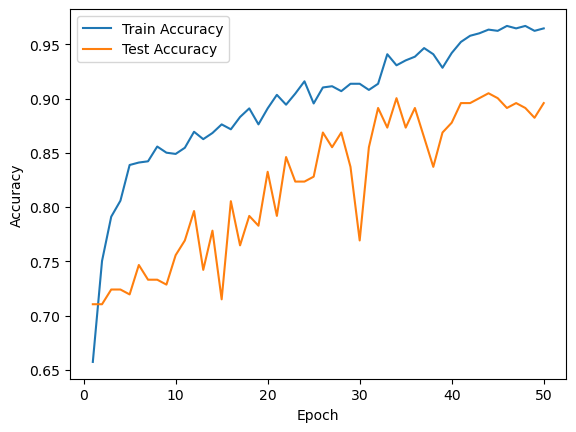

Execution time: 2012.55 seconds


In [9]:
import time

# Model setup
epochs = 50
modelname = 'Pos_ResNetKD'

# Load student and teacher models
student_model = TemporalResNet(input_channels=vid_channels, num_classes=num_classes, num_blocks=14)
teacher_model = TemporalResNetMultiInput(imu_channels, vid_channels, num_classes, num_blocks=14)
teacher_model.load_state_dict(torch.load('/Volumes/Data_Drive/vidimu_gridsearch_out/gridsearch_11_4/best_AngPos_ResNet_fold1_14_4.0_42_acc_0.8778.pth', weights_only=True))
teacher_model.eval()  # Set teacher model to evaluation mode

# Distillation loss function
alpha = 0.7  # Weight for distillation loss
temperature = 5

def distillation_loss(student_logits, teacher_logits, true_labels):
    # Standard cross-entropy loss for true labels
    hard_loss = nn.CrossEntropyLoss()(student_logits, true_labels)
    
    # KL divergence for soft labels from teacher
    soft_teacher_probs = nn.functional.softmax(teacher_logits / temperature, dim=1)
    soft_student_probs = nn.functional.log_softmax(student_logits / temperature, dim=1)
    distill_loss = nn.functional.kl_div(soft_student_probs, soft_teacher_probs, reduction='batchmean') * (temperature ** 2)
    
    # Weighted sum of hard and soft losses
    return alpha * distill_loss + (1 - alpha) * hard_loss

# Optimizer and scheduler
optimizer = optim.Adam(student_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

# Train and evaluate the student model with distillation
initial_model_path = '/Volumes/Data_Drive/vidimu_gridsearch_out/gridsearch_11_4/best_Pos_ResNet_fold1_14_4.0_42_acc_0.7692.pth'  # Set to a path if you want to start from a previously saved student model
start_time = time.time()
best_accuracy = train_distillation(student_model, teacher_model, train_loader, test_loader, distillation_loss, optimizer, scheduler, modelname, num_epochs=epochs, model_path=initial_model_path)
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")

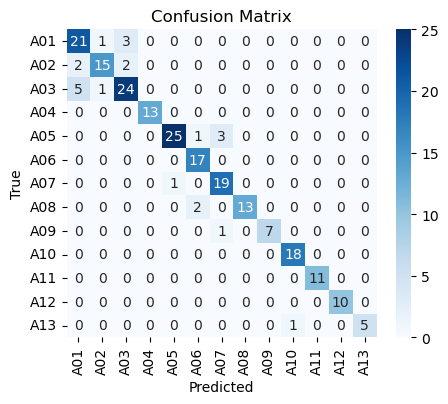

Test Accuracy: 0.8959
Precision (Macro Average): 0.9265
Recall (Macro Average): 0.9090
F1-Score (Macro Average): 0.9150
Ground truth: A11, Predicted: A11


In [10]:
# Run the updated test function on the test set
test_model(student_model, test_loader)

# Inference function for single sample
def load_and_sample_predict(vid_input, model_path='best_model.pth'):
    # Initialize and load the saved student model
    best_model = TemporalResNet(input_channels=vid_channels, num_classes=num_classes, num_blocks=14)
    best_model.load_state_dict(torch.load(model_path, weights_only=True))
    best_model.eval()

    # Perform prediction
    with torch.no_grad():
        vid_input = torch.tensor(vid_input).unsqueeze(0).float()  # Add batch dimension
        output = best_model(vid_input)

        # Get predicted class index
        _, predicted_label = torch.max(output, 1)
        return predicted_label.item()

# Fetch one batch and sample from it
vid_batch, _, label_batch = next(iter(test_loader))  # Get one batch

# Use the first sample from the batch for inference
sample_vid_input = vid_batch[0].numpy()  # Convert to numpy for input
true_label = activities[label_batch[0].item()]

# Predict using the best model saved after training
model_path = f'{model_out_path}/best_{modelname}_acc_{best_accuracy:.4f}.pth'
predicted_label = load_and_sample_predict(sample_vid_input, model_path)
print(f"Ground truth: {true_label}, Predicted: {activities[predicted_label]}")

In [13]:
2013/3600

0.5591666666666667